In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


In [2]:
# Load data
cancer_dir = pathlib.Path("data/unhealthy")
normal_dir = pathlib.Path("data/healthy")
classes = ['normal', 'cancer']
labels_dict = {'cancer': 1, 'normal': 0}

filepaths, labels = [], []
for dir_path, label in zip([normal_dir, cancer_dir], classes):
    for file in dir_path.glob("*"):
        filepaths.append(str(file))
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

C:\Users\anndy\AppData\Local\Temp\ipykernel_12396\1476665997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


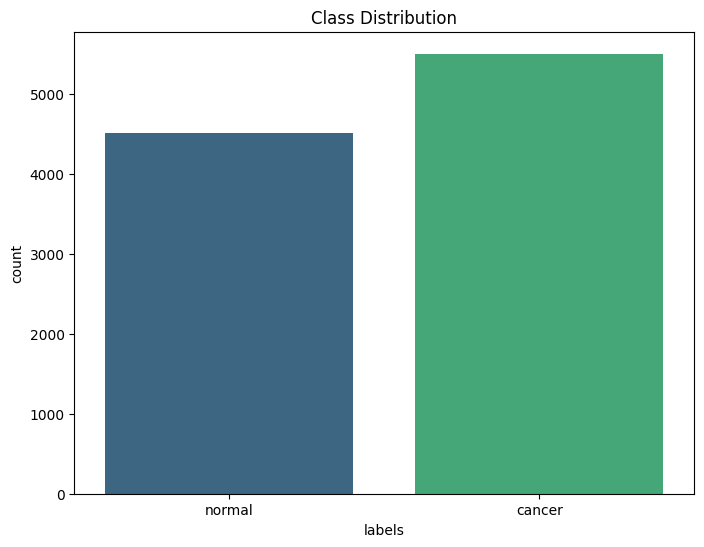

In [3]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Class Distribution")
plt.show()

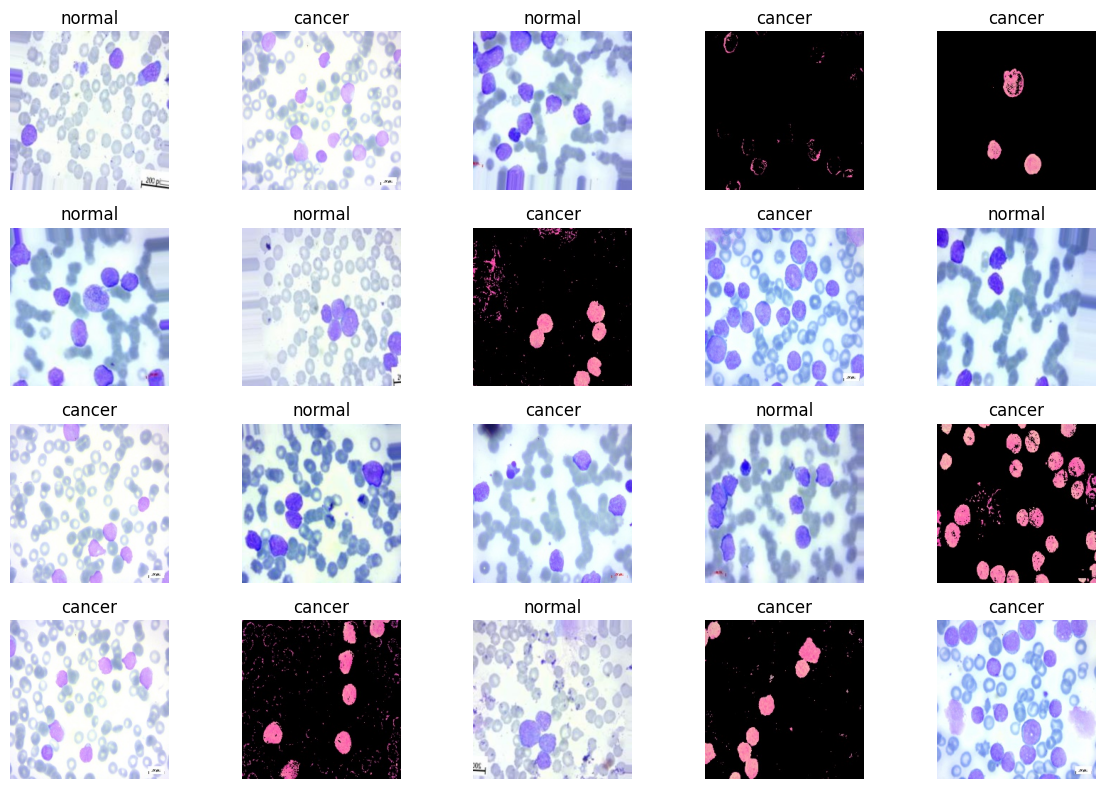

In [4]:
# Display random samples
plt.figure(figsize=(12, 8))
for i in range(20):
    random_idx = np.random.randint(0, len(df))
    plt.subplot(4, 5, i + 1)
    img = Image.open(df.loc[random_idx, "filepaths"])
    plt.imshow(img)
    plt.title(df.loc[random_idx, "labels"])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [6]:
# Image data generator
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=True
)

val = image_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False
)

test = image_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False
)


Found 5606 validated image filenames belonging to 2 classes.
Found 1402 validated image filenames belonging to 2 classes.
Found 3004 validated image filenames belonging to 2 classes.


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision for faster training
set_global_policy('mixed_float16')

# Image data generator
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Train, validation, and test data generators
train = image_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=True
)

val = image_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False
)

test = image_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False
)

# Optimized function to prepare LSTM data
def prepare_lstm_data(generator):
    steps = len(generator)
    batch_size = generator.batch_size
    num_classes = len(generator.class_indices)  # Use class_indices to get the number of classes
    input_shape = generator.image_shape

    # Preallocate memory for data
    X = np.zeros((steps * batch_size, input_shape[0] * input_shape[1], input_shape[2]), dtype=np.float32)
    y = np.zeros((steps * batch_size, num_classes), dtype=np.float32)

    idx = 0
    for i in range(steps):
        X_batch, y_batch = generator[i]
        batch_size_actual = X_batch.shape[0]  # Handle last batch size
        X[idx:idx + batch_size_actual] = X_batch.reshape(batch_size_actual, -1, input_shape[2])
        y[idx:idx + batch_size_actual] = y_batch
        idx += batch_size_actual

    # Trim excess preallocated space (if any)
    X = X[:idx]
    y = y[:idx]
    return X, y

# Prepare LSTM data
train_X, train_y = prepare_lstm_data(train)
val_X, val_y = prepare_lstm_data(val)

Found 5606 validated image filenames belonging to 2 classes.
Found 1402 validated image filenames belonging to 2 classes.
Found 3004 validated image filenames belonging to 2 classes.


In [8]:
''' from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Build and compile optimized BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    Dropout(0.3),
    Dense(2, activation='softmax', dtype='float32')  # Ensure output layer uses float32
])

# Compile the model with AdamW optimizer and learning rate scheduler
bilstm_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
) '''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Build and compile optimized BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'), 
                  input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(GRU(16, return_sequences=False, activation='tanh', recurrent_activation='sigmoid')),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced units
    Dropout(0.3),
    Dense(2, activation='softmax', dtype='float32')  # Ensure output layer uses float32
])

# Compile the model with Adam optimizer and learning rate scheduler
bilstm_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\anndy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the file path to save the model
checkpoint_filepath = 'bilstm_model_checkpoint.keras'

# Callback for saving the model at the end of each epoch
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,  # Save only the best model based on validation loss
    verbose=1
)

# Train the model with the ModelCheckpoint callback
history = bilstm_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=5,  # Adjust as needed
    batch_size=32,
    callbacks=[model_checkpoint],  # Removed EarlyStopping
    verbose=1
)

Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 0.6524 - loss: 1.0080 
Epoch 1: val_loss improved from inf to 0.76606, saving model to bilstm_model_checkpoint.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 8555s 49s/step - accuracy: 0.6526 - loss: 1.0074 - val_accuracy: 0.7953 - val_loss: 0.7661
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.7720 - loss: 0.6897 
Epoch 2: val_loss improved from 0.76606 to 0.67987, saving model to bilstm_model_checkpoint.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 7638s 43s/step - accuracy: 0.7720 - loss: 0.6896 - val_accuracy: 0.6833 - val_loss: 0.6799
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.7976 - loss: 0.5787 
Epoch 3: val_loss improved from 0.67987 to 0.52420, saving model to bilstm_model_checkpoint.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 7196s 41s/step - accuracy: 0.7976 - loss: 0.5786 - val_accuracy: 0.8131 - val_loss: 0.5242
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.8182 - loss: 0.4931 
Epoch 

In [10]:
from tensorflow.keras.models import load_model

# Load the last saved model
bilstm_model = load_model('bilstm_model_checkpoint.keras')


In [ ]:
history = bilstm_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=10,  # Continue for more epochs
    batch_size=32,
    callbacks=[model_checkpoint],  # Keep saving the best model
    verbose=1
)


In [11]:

# Evaluate on test data
test_X, test_y = prepare_lstm_data(test)
test_loss, test_accuracy = bilstm_model.evaluate(test_X, test_y)
print(f"Test Accuracy: {test_accuracy:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8526 - loss: 0.4070
Test Accuracy: 0.84


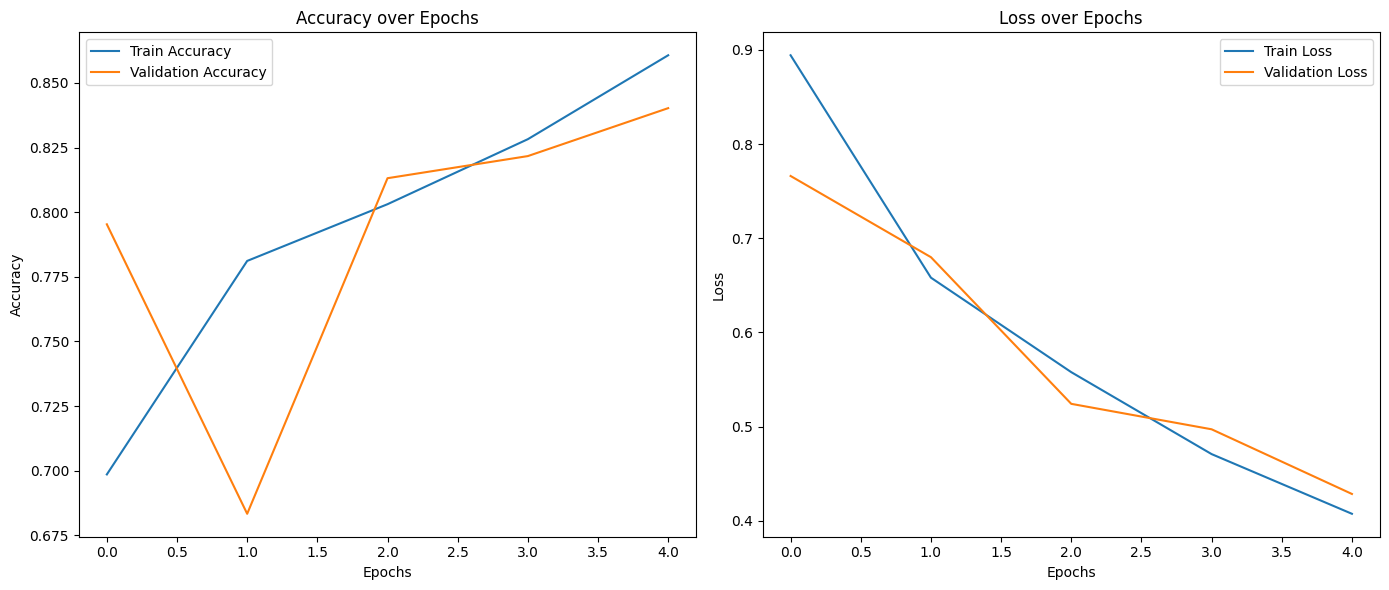

In [12]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step


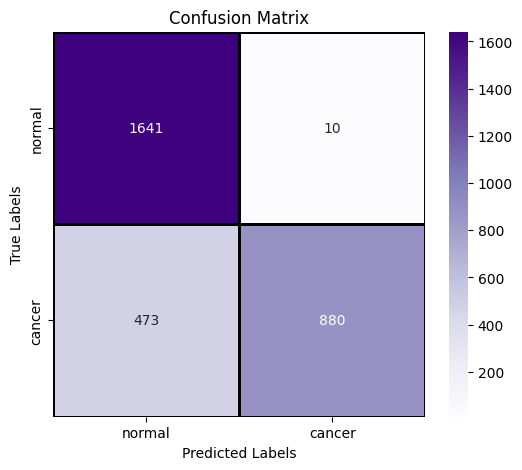

94/94 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step


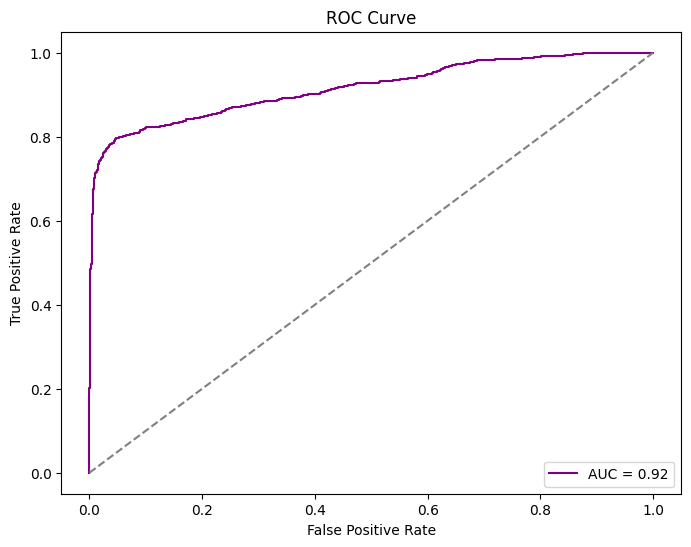

In [13]:
# ROC Curve
predictions = np.argmax(bilstm_model.predict(test_X), axis=-1)
true_labels = np.argmax(test_y, axis=-1)
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples', linecolor='black', linewidth=1)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

y_pred_probs = bilstm_model.predict(test_X)[:, 1]
fpr, tpr, _ = roc_curve(true_labels, y_pred_probs)
roc_auc = roc_auc_score(true_labels, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()